This is really to clean the code...\
Come one, let's do it.

First, import some modules...

In [16]:
from __future__ import division
import sys
sys.path.insert(0, '/home/gw2397/cluster_new')
sys.path.insert(0, '/home/gw2397/pyhsmm-autoregressive-master')
sys.path.insert(0, '/home/gw2397/nbRegg_mcmc')

import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import *
from scipy.interpolate import *
from cluster_functions import *
import scipy

import pyhsmm
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.stats import whiten, cov

import autoregressive.models as m
import autoregressive.distributions as d

from polyagamma import random_polyagamma
import numpy as np
from pyhmc import hmc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gamma, digamma
from scipy.stats import norm, nbinom, multivariate_normal
from tqdm import tqdm
import heapq

import numpy.matlib
import time
from IPython import display

import warnings
import copy
warnings.filterwarnings("ignore")

In [17]:
# def constraint(muX_a, C_a, delt_a, dynamics_a, Z_tmp, muX_pre = None):
    
#     # to debug...
#     # muX_a = muX_fit[gg]
#     # C_a = C_fit[gg-1,:,:]
#     # delt_a = delt_fit[gg-1,:].reshape((-1, 1))
#     # dynamics_a = dynamics_fit[gg-1]
#     # Z_tmp = Z_fit[gg-1,:]
#     # muX_pre = muX_fit[gg-1]

#     muX_b = copy.deepcopy(muX_a)
#     C_b = copy.deepcopy(C_a)
#     delt_b = copy.deepcopy(delt_a)
#     dynamics_b = copy.deepcopy(dynamics_a)
#     lab_unique = np.unique(Z_tmp)

#     lat_dim = dynamics_b['As'].shape[1]
#     trans_all = np.zeros((lat_dim,1))
#     rot_all = np.eye(lat_dim)

#     p_tmp = C_a.shape[1]
#     perm_idx = np.repeat(np.arange(0,p_tmp),2)
#     sign_idx = np.tile([1, -1], p_tmp)
#     idx_raw = np.arange(0, 2*p_tmp)

#     for ll in lab_unique:

#         muX_bar = np.mean(muX_b[ll], axis = 1).reshape((-1, 1))
#         obsIdx = Z_tmp == ll
#         n_tmp = np.sum(obsIdx)

#         # (1) translation
#         muX_b[ll] = muX_b[ll] - muX_bar
#         delt_b[obsIdx] = delt_b[obsIdx] + np.hstack((np.ones((n_tmp,1)), C_b[obsIdx,:])) @ muX_bar
#         trans_all[(ll*(p_tmp+1)):((ll+1)*(p_tmp+1))] = muX_bar

#         # (2) rotation: be careful...
#         C_tmp = C_a[obsIdx,:]
#         X_tmp = muX_b[ll][1:,:].copy()
#         if n_tmp > 1:
#             if n_tmp > 2:
#                 U, S, Vh = scipy.sparse.linalg.svds(C_tmp @ X_tmp, k = p_tmp)
#             else:
#                 U, S, Vh = np.linalg.svd(C_tmp @ X_tmp, full_matrices= False)

#             SVh = np.diag(S) @ Vh

#             if muX_pre is not None:
#                 X_tmp_pre = muX_pre[ll][1:,:].copy()
#                 min_indx = np.zeros((p_tmp,), dtype = int)
#                 idx_set = np.arange(0, 2*p_tmp)
#                 Xout = np.zeros_like(SVh)

#                 for rr in range(p_tmp):
#                     mse_tmp = np.zeros((2*p_tmp,))
#                     for cc in range(2*p_tmp):
#                         mse_tmp[cc] = np.mean((X_tmp_pre[rr,:] - sign_idx[cc]*SVh[perm_idx[cc],:])**2)
#                     sorted_ind = np.argsort(mse_tmp)
#                     min_indx[rr] = sorted_ind[np.isin(sorted_ind, idx_set)][0]
#                     Xout[rr,:] = sign_idx[min_indx[rr]]*SVh[perm_idx[min_indx[rr]],:]
#                     idx_set = idx_set[~np.isin(idx_set, idx_raw[perm_idx == perm_idx[min_indx[rr]]])]


#                 U = U[:,perm_idx[min_indx]]
#                 U = U @ np.diag(sign_idx[min_indx])
#                 C_b[obsIdx,:] = U

#             else:
#                 Xout = SVh
#                 C_b[obsIdx,:] = U

#             M_dag = U.T @ C_tmp
#             muX_b[ll][1:,:] = Xout

#             rot_all[(ll*(p_tmp+1)+1):((ll+1)*(p_tmp+1)), (ll*(p_tmp+1)+1):((ll+1)*(p_tmp+1))] = M_dag
#         else:
#             norm_C = np.linalg.norm(C_tmp)
#             U, S, Vh = np.linalg.svd(X_tmp.T, full_matrices= False)
#             US = U @ np.diag(S)

#             if muX_pre is not None:
#                 X_tmp_pre = muX_pre[ll][1:,:].copy()
#                 min_indx = np.zeros((p_tmp,), dtype = int)
#                 idx_set = np.arange(0, 2*p_tmp)
#                 Xout = np.zeros_like(US.T)

#                 for rr in range(p_tmp):
#                     mse_tmp = np.zeros((2*p_tmp,))
#                     for cc in range(2*p_tmp):
#                         mse_tmp[cc] = np.mean((X_tmp_pre[rr,:] - sign_idx[cc]*norm_C*US[:,perm_idx[cc]])**2)
#                     sorted_ind = np.argsort(mse_tmp)
#                     min_indx[rr] = sorted_ind[np.isin(sorted_ind, idx_set)][0]
#                     Xout[rr,:] = sign_idx[min_indx[rr]]*norm_C*US[:,perm_idx[min_indx[rr]]]
#                     idx_set = idx_set[~np.isin(idx_set, idx_raw[perm_idx == perm_idx[min_indx[rr]]])]

#                 # sign
#                 Vh = Vh[perm_idx[min_indx],:]
#                 Vh = Vh @ np.diag(sign_idx[min_indx])

#             else:
#                 Xout = norm_C*US.T

#             M_dag = norm_C * Vh

#             muX_b[ll][1:,:] = Xout
#             rot_all[(ll*(p_tmp+1)+1):((ll+1)*(p_tmp+1)), (ll*(p_tmp+1)+1):((ll+1)*(p_tmp+1))] = M_dag
#             C_b[obsIdx,:] = C_b[obsIdx,:] @ np.linalg.inv(M_dag)


#     # for linear dyanmics (A, b, Q)...
#     for mm in range(dynamics_b['As'].shape[0]):

#         # (1) translation
#         dynamics_b['bs'][mm,:] = ((dynamics_b['As'][mm,:,:] - np.eye(lat_dim)) @ trans_all).ravel() + dynamics_b['bs'][mm,:]

#         # (2) rotation
#         dynamics_b['As'][mm,:,:] = rot_all @ dynamics_b['As'][mm,:,:] @ np.linalg.inv(rot_all)
#         dynamics_b['bs'][mm,:] = (rot_all @ dynamics_b['bs'][mm,:].reshape((-1, 1))).ravel()
#         dynamics_b['Qs'][mm,:,:] = rot_all @ dynamics_b['Qs'][mm,:,:] @ rot_all.T

#     return muX_b, C_b, delt_b.ravel(), dynamics_b

# Data Generation

In [18]:
n = 10
nClus = 3
p = 2
T = 500

np.random.seed(0)
lab_neuron = np.repeat(np.arange(nClus), n)

dd = np.random.normal(size = (n*nClus,1))*0.5
C_true= np.random.normal(size = (nClus*n,p))*0.6


    
## option 1: enerate data from linear dynamics...

# sim 1
# As = [block_diag(0.01*np.eye(p+1), 
#                  0.01*np.eye(p+1), 
#                  0.01*np.eye(p+1)),
#       block_diag(random_rotation(p+1, theta= np.pi/20),
#                  random_rotation(p+1, theta= np.pi/20),
#                  random_rotation(p+1, theta= np.pi/20))]

# sim 2
As = [block_diag(0.005*np.eye(p+1), 
                 0.005*np.eye(p+1), 
                 0.005*np.eye(p+1)),
      block_diag(1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20),
                 1.01*random_rotation(p+1, theta= np.pi/20))]





truemodel = m.ARHSMM(
        alpha=5.,init_state_concentration=5.,
        obs_distns=[d.AutoRegression(A=A,sigma=np.eye(nClus*(p+1))*1e-2) for A in As],
        dur_distns=[pyhsmm.basic.distributions.PoissonDuration(alpha_0=100,beta_0=2)
            for state in range(len(As))],
        )


X_all_tmp, lab_t_tmp = truemodel.generate(2*T, keep=True)
X_all = X_all_tmp[501:,:].T
lab_t = lab_t_tmp[500:]

## option 2: generate offline (2 states: fast & slow)
# 1. slow period: 5 query points
# 2. fast period: 20 query points

# n_state = 2 # fast & slow
# cycle = 5
# duration = np.ceil(T/(cycle*n_state)).astype(int)
# t_cyc_all = n_state*cycle*duration
# lab_t = np.zeros((T,))
# if t_cyc_all < T:
#     lab_t[0:t_cyc_all] = np.repeat(np.tile([0,1], cycle), duration)
#     lab_t[t_cyc_all:] = np.ones((T - t_cy_all,))*lab_t[t_cyc_all]
# else:
#     lab_t = np.repeat(np.tile([0,1], cycle), duration)
# lab_t = lab_t.astype(int)


# nq = [5,25]
# query_pts = np.array([], dtype = int)
# for cyc in range(cycle):
#     idx0 = np.arange(2*cyc*(duration), (2*cyc+1)*duration)
#     idx1 = np.arange((2*cyc+1)*duration, 2*(cyc+1)*(duration)) 
#     idx0_samp = np.random.choice(idx0[1:], nq[0]-1, replace = False)
#     idx1_samp = np.random.choice(idx1[:-1], nq[1]-1, replace = False)
#     idx0_samp = np.append(idx0[0], idx0_samp)
#     idx1_samp = np.append(idx1[-1], idx1_samp)
#     query_pts = np.append(query_pts, np.concatenate((idx0_samp, idx1_samp), axis=None))
    

# query_pts = np.sort(query_pts)
    
# X_all = np.ones((nClus*(p+1),T))*np.Inf
# for cc in range(nClus):
#     for ll in range(p+1):
#         while np.sum(np.abs(X_all[cc*(p+1)+ll,:]) > 2) > 1:
#             f = splrep(query_pts, np.random.uniform(-.2,.2,size = query_pts.size))
#             X_all[cc*(p+1)+ll,:] = splev(np.arange(T), f)
#             X_all[cc*(p+1)+ll,:] = X_all[cc*(p+1)+ll,:] - np.mean(X_all[cc*(p+1)+ll,:])


muX_all = []
for cc in range(nClus):
    muX_all.append(X_all[(cc*(p+1)):((cc+1)*(p+1)),:])
    
dynm = {}
dynm['As'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['bs'] = np.zeros((2,3*(p+1)))
dynm['Qs'] = np.zeros((2,3*(p+1),3*(p+1)))
dynm['states'] = np.zeros((T,), dtype = int)


# muX_b, C_b, delt_b.ravel(), dynamics_b

muX_all, C_true, _, _ = constraint(muX_all, C_true,dd.reshape((-1, 1)),dynm, lab_neuron)    
X_all = np.zeros_like(X_all)
for cc in range(nClus):
    X_all[(cc*(p+1)):((cc+1)*(p+1)),:] = muX_all[cc]

    
C_trans = np.zeros((n*nClus, (p+1)*nClus))
for cc in range(nClus):
    C_trans[(n*cc):(n*(cc+1)),(cc*(p+1)):((cc+1)*(p+1))] = np.column_stack((np.ones((n,1)), C_true[(n*cc):(n*(cc+1)),:]))    
    
Lam_true = np.exp(dd + C_trans @ X_all)
r_true = np.ones((n*nClus,1))*10
p_true = r_true/(r_true+Lam_true)
y = np.random.negative_binomial(r_true, p_true, size=None)
# Lam_true = np.exp(dd + C_trans @ X_all)
# y =np.random.poisson(Lam_true)


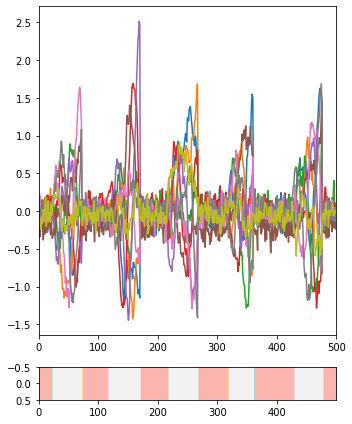

In [19]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]})

a0.plot(X_all .T)
a0.set_xlim([0, T])
a1.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')

f.tight_layout()

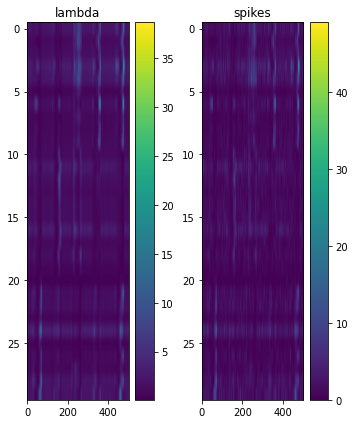

In [20]:
fig, ax = plt.subplots(1,2)

z1 = ax[0].imshow(Lam_true, aspect='auto')
ax[0].set_title('lambda')
plt.colorbar(z1, ax= ax[0])

z2 = ax[1].imshow(y, aspect='auto')
ax[1].set_title('spikes')
plt.colorbar(z2, ax= ax[1])

fig.tight_layout()

# MCMC original

In [22]:
N = n*nClus
n_iter = 1000
t_max = int(N/2)
state_max = 5

## neuron-clustering realted
# DPMM:
# DPMM = True
# alpha_random = True
sigma_alpha = 0.1 # scale for MH proposals in alpha move
alphaDP = 1
# log_v = np.arange(1, t_max + 2)*np.log(alphaDP) - lAbsGam(alphaDP+N) + lAbsGam(alphaDP)
# a = 1
# b = 0

# MFM:
DPMM = False
alpha_random = False
MFMgamma = 1
# K ~ Geometric(r)
r = 0.2
log_pk = lambda k: np.log(r) + (k-1)*np.log(1-r)

a = MFMgamma
b = MFMgamma
log_v = MFMcoeff(log_pk, MFMgamma, N, t_max + 1)
logNb = np.log(np.arange(1,N+1) + b)

## state-clustering related
alpha_slds = 2.
gamma_slds = 4.
kappa_slds = 10

## other priors
prior = {}
prior['x0'] = np.zeros((p+1,1))
prior['Q0'] = np.eye(p+1)
prior['muC0'] = np.zeros((p,))
prior['SigC0'] = np.eye(p)
prior['mud0'] = 0
prior['s2d0'] = 1

prior['bA0'] = np.hstack((np.eye(p+1), np.zeros((p+1, 1))))
prior['Lam0'] = np.eye(p+1+1)
prior['Nu0'] = p+1+2
prior['Sig0'] = np.eye(p+1)*1e-2
a0 = 1
h = 1


## pre-allocation
t_fit = np.zeros((n_iter,), dtype = int)
Z_fit = np.zeros((n_iter, N), dtype = int)
numClus_fit = np.zeros((n_iter, t_max + 3), dtype = int)
actList_fit = np.ones((n_iter, t_max + 3), dtype = int)*-99 # different from MATLAB, cannot use 0 here

delt_fit = np.zeros((n_iter, N))
C_fit = np.zeros((n_iter, N, p))
muX_fit = [ [np.zeros((p+1, T)) for _ in range(t_max)] for _ in range(n_iter)]
dynamics_fit = []
for _ in range(n_iter):
    dynm = {}
    dynm['As'] = np.zeros((state_max,t_max*(p+1),t_max*(p+1)))
    dynm['bs'] = np.zeros((state_max,t_max*(p+1)))
    dynm['Qs'] = np.zeros((state_max,t_max*(p+1),t_max*(p+1)))
    dynm['states'] = np.zeros((T,), dtype = int)
    
    dynamics_fit.append(dynm)
    
r_fit = np.ones((n_iter, N))


## initialization

# start from 1 cluster
t_fit[0] = 1
Z_fit[0,:] = np.zeros((N,),dtype = int)
numClus_fit[0,0] = N
actList_fit[0,0] = 0
c_next = 1

delt_fit[0,:] = np.random.normal(prior['mud0'], prior['s2d0'], size = N)
C_fit[0,:] = np.random.multivariate_normal(prior['muC0'], prior['SigC0'], size = N)

for ii in range(n_iter):
    for qq in range(state_max):
        dynamics_fit[ii]['As'][qq,:,:] = np.eye(t_max*(p+1))
        dynamics_fit[ii]['Qs'][qq,:,:] = np.eye(t_max*(p+1))*1e-2

    
## the muX is initialized with FFBS(moothing) for NB-DGLM (local normal approximation): do it if I have time to kill...
## currently, just generate muX offline...

# for ii in range(n_iter):
#     for jj in range(t_max):
#         muX_fit[ii][jj] = sample_muX(p,T)

for jj in range(t_max):
    muX_fit[0][jj] = sample_muX(p,T)
    
muX_fit[0], C_fit[0,:], delt_fit[0,:], dynamics_fit[0] = constraint(muX_fit[0], C_fit[0,:,:],
                                                                    delt_fit[0,:].reshape((-1, 1)),
                                                                    dynamics_fit[0], Z_fit[0,:])

splitMerge_flag = False
splitL = 1
nSplit = 5
nMerge = 5

dynamics_sm = {}
dynamics_sm['As'] = np.zeros((state_max,p+1,p+1))
dynamics_sm['bs'] = np.zeros((state_max,p+1))
dynamics_sm['Qs'] = np.zeros((state_max,p+1,p+1))
dynamics_sm['states'] = np.zeros((T,), dtype = int)
dynamics_sm['As'][0,:,:] = np.eye(p+1)
dynamics_sm['Qs'][0,:,:] = np.eye(p+1)*1e-2

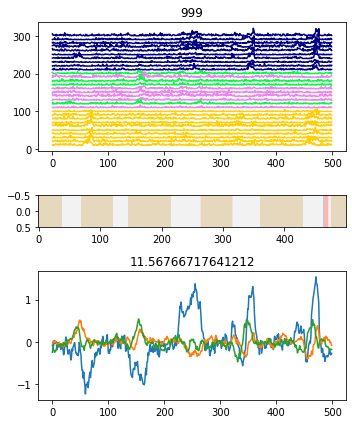

100%|██████████| 999/999 [33:38<00:00,  2.02s/it]


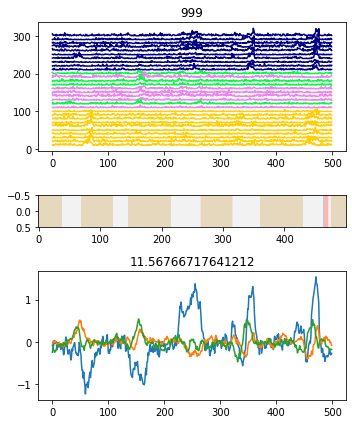

In [23]:
plt.rcParams['figure.figsize'] = [5, 6]

figure, (ax0, ax1, ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [4, 1, 4]})
Yplot, z2, colors = clusterPlot_values(y,Z_fit[0,:])
line1 = ax0.plot(Yplot.T)
for mm in range(Yplot.shape[0]):
    line1[mm].set_color(colors[z2[mm]])
ax0.set_title(0)
ax1.imshow(dynamics_fit[0]['states'][None,:], aspect="auto", cmap='Pastel1')
ax2.plot(muX_fit[0][Z_fit[0,0]].T)
figure.tight_layout()

keep_flg = False
state_rep = 1
for gg in tqdm(range(1,n_iter)):
    
    #### 0. store previous steps
    muX_tmp = muX_fit[gg-1].copy()
    delt_tmp = delt_fit[gg-1,:].reshape((-1, 1)).copy()
    C_tmp = C_fit[gg-1,:,:].copy()
    r_tmp = r_fit[gg-1,:].reshape((-1, 1)).copy()
    dynamics_tmp = dynamics_fit[gg-1].copy()
    Z_tmp = Z_fit[gg-1,:].copy()

    #### 1. sample dynamical latents
    ## 1a. select corresponding muX & expand C to block diag
    lab_n_unique = sorted(set(Z_tmp))
    n_lab_n = len(lab_n_unique)
    lab_n_unique_dic = {}
    for kk in range(n_lab_n):
        lab_n_unique_dic[lab_n_unique[kk]] = kk

    muX_sel = np.zeros((n_lab_n*(p+1), T))

    As_sel = np.zeros((state_max,n_lab_n*(p+1),n_lab_n*(p+1)))
    bs_sel = np.zeros((state_max, n_lab_n*(p+1)))
    Qs_sel = np.zeros((state_max,n_lab_n*(p+1),n_lab_n*(p+1)))
    C_trans = np.zeros((N, n_lab_n*(p+1)))

    sel_idx = np.array([], dtype = int)
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_sel[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:] = muX_tmp[sn]
        sel_idx = np.append(sel_idx, np.arange(sn*(p+1), (sn+1)*(p+1)))

    for st in range(state_max):
        As_sel[st,:,:] = dynamics_tmp['As'][st,:,:][np.ix_(sel_idx, sel_idx)]
        bs_sel[st,:] = dynamics_tmp['bs'][st,sel_idx]
        Qs_sel[st,:,:] = dynamics_tmp['Qs'][st,:,:][np.ix_(sel_idx, sel_idx)]


    for n_id, zz in enumerate(Z_tmp):
        idx_tmp = lab_n_unique_dic[zz]
        C_trans[n_id, (idx_tmp*(p+1)):((idx_tmp+1)*(p+1))] = np.hstack((1, C_tmp[n_id, :]))

    ## 1b. sample mu & X

    # 1b.01 PG augmentation (transform Y)
    omega = random_polyagamma(r_tmp + y, delt_tmp + C_trans @ muX_sel - np.log(r_tmp))
    kappa = (y-r_tmp)/2 + omega*(np.log(r_tmp) - delt_tmp)
    y_hat = (1/omega)*kappa

    # 1b.02 FFBS
    x0_tmp = np.repeat(prior['x0'], n_lab_n).reshape((-1, 1))
    Q0_tmp = np.kron(np.eye(n_lab_n,dtype=int),prior['Q0'])
    muX_update = FFBS(y_hat,C_trans, 1/omega, dynamics_tmp['states'], As_sel, bs_sel, Qs_sel, x0_tmp, Q0_tmp)
    
#     for sn in lab_n_unique:
#         idx_tmp = lab_n_unique_dic[sn]
#         muX_fit[gg][sn] = muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]
    
#     muX_fit[gg], C_fit[gg-1,:,:], delt_fit[gg-1,:], dynamics_fit[gg-1] = constraint(muX_fit[gg], C_fit[gg-1,:,:],
#                                                                               delt_fit[gg-1,:].reshape((-1, 1)),
#                                                                               dynamics_fit[gg-1], Z_fit[gg-1,:], muX_fit[gg-1])
    
#     for sn in lab_n_unique:
#         idx_tmp = lab_n_unique_dic[sn]
#         muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:] = muX_fit[gg][sn]
    
    
    ## 1c. sample states & dynamics (b, A & Q)

    Nu0_tmp = n_lab_n*(p+1)+2
    Sig0_tmp = np.kron(np.eye(n_lab_n,dtype=int),prior['Sig0'])
    # bA0_tmp = np.hstack((np.eye(n_lab_n*(p+1)), np.zeros((n_lab_n*(p+1), 1))))
    bA0_tmp = np.hstack((np.kron(np.eye(n_lab_n,dtype=int),prior['bA0'][:,0:-1]), np.repeat(prior['bA0'][:,-1], n_lab_n).reshape((-1, 1))))
    Lam0_tmp = np.eye(n_lab_n*(p+1)+1)

    model = m.ARWeakLimitStickyHDPHMM(
        alpha=alpha_slds, gamma=gamma_slds, kappa=kappa_slds, 
        init_state_distn='uniform',
        obs_distns=[d.AutoRegression(nu_0=Nu0_tmp,S_0=Sig0_tmp,
                                     M_0=bA0_tmp,K_0=Lam0_tmp,affine=True) for state in range(state_max)],)
    model.add_data(muX_update.T)
    
    if (gg > 0.05*n_iter and max([np.sum(dynamics_tmp['states'] == s) for s in np.unique(dynamics_tmp['states'])]) > 0.7*T):
        keep_flg = False
        
    if keep_flg:
        model.states_list[0].stateseq = dynamics_tmp['states'][0:-1].astype(np.int32).copy()
    else:
        if (gg > 0.05*n_iter and max([np.sum(dynamics_tmp['states'] == s) for s in np.unique(dynamics_tmp['states'])]) < 0.6*T):
            model.states_list[0].stateseq = dynamics_tmp['states'][0:-1].astype(np.int32).copy()
            keep_flg = True
            print('change')

    for _ in range(state_rep):
        model.resample_model()


    ## 1d. allocation back...

    # states
    dynamics_fit[gg]['states'][0:-1] = model.states_list[0].stateseq.copy()
    dynamics_fit[gg]['states'][-1] = dynamics_fit[gg]['states'][-2].copy()

    # muX
    for sn in lab_n_unique:
        idx_tmp = lab_n_unique_dic[sn]
        muX_fit[gg][sn] = muX_update[(idx_tmp*(p+1)):((idx_tmp+1)*(p+1)),:]

    # linear dynamics (b, A, Q): this redundant, only assign used states later...
    # no time to do it now...
    for idx, s in enumerate(model.obs_distns):
        dynamics_fit[gg]['bs'][idx,sel_idx] = s.A[:,-1]
        dynamics_fit[gg]['As'][idx,:,:][np.ix_(sel_idx, sel_idx)] = s.A[:,:-1]
        dynamics_fit[gg]['Qs'][idx,:,:][np.ix_(sel_idx, sel_idx)] = s.sigma



    #### 2. sample loadings (delt, C)
    delt_b, C_b = update_deltC(delt_fit[gg-1,:].reshape((-1, 1)), C_fit[gg-1,:,:], y,
                               r_fit[gg-1,:].ravel(), Z_fit[gg-1,:].ravel(), muX_fit[gg], prior)
    delt_fit[gg,:] = delt_b.ravel()
    C_fit[gg,:,:] = C_b

    #### 3. sample r
    delt_tmp = delt_fit[gg,:].reshape((-1, 1))
    C_trans = np.zeros((N, n_lab_n*(p+1)))
    for n_id, zz in enumerate(Z_tmp):
        idx_tmp = lab_n_unique_dic[zz]
        C_trans[n_id, (idx_tmp*(p+1)):((idx_tmp+1)*(p+1))] = np.hstack((1, C_fit[gg,n_id,:]))
    Mu_r = np.exp(delt_tmp + C_trans @ muX_update)

    try: 
        r_fit[gg,:] = update_r(y,Mu_r,r_fit[gg-1,:], a0=a0, h=h, use_hmc=False)
    except: 
        r_fit[gg,:] = update_r(y,Mu_r,r_fit[gg-1,:], a0=a0, h=h, use_hmc=True)


    #### 4. projection    
    muX_fit[gg], C_fit[gg,:,:], delt_fit[gg,:], dynamics_fit[gg] = constraint(muX_fit[gg], C_fit[gg,:,:],
                                                                              delt_fit[gg,:].reshape((-1, 1)),
                                                                              dynamics_fit[gg], Z_fit[gg-1,:], muX_fit[gg-1])

    muX_tmp, C_tmp, dynamics_tmp, M1_tmp = contraint_ortho(muX_fit[gg], C_fit[gg,:,:], dynamics_fit[gg], Z_fit[gg-1,:])

    #### 5. clustering...
    # 5a. use split-merge...
    if splitMerge_flag and (gg % 20 == 1):

        Z_fit[gg-1,:], numClus_fit[gg-1,:], t_fit[gg-1], actList_fit[gg-1,:], muX_tmp, delt_fit[gg,:], C_tmp, dynamics_tmp= \
        splitMerge(Z_fit[gg-1,:], numClus_fit[gg-1,:], t_fit[gg-1], actList_fit[gg-1,:],
                   muX_tmp,delt_fit[gg,:].reshape((-1, 1)),C_tmp,y,r_fit[gg,:],dynamics_sm,prior,
                   a, b, log_v,np.random.binomial(1, .5), nSplit, nMerge,dynamics_tmp)

        c_next = ordered_next(actList_fit[gg-1,:])


    # 5b. regular
    if gg % 10 == 1: sample_tag = 1
    else: sample_tag = 0

    Z_fit[gg,:], numClus_fit[gg,:], t_fit[gg], actList_fit[gg,:], c_next, muX_tmp, dynamics_tmp = \
    update_cluster(Z_fit[gg-1,:], numClus_fit[gg-1,:], t_fit[gg-1], actList_fit[gg-1,:],
                   c_next,DPMM, alpha_random,
                   a, log_v, logNb, muX_tmp, delt_fit[gg,:].reshape((-1, 1)),
                   y, r_fit[gg,:], prior, alphaDP,sigma_alpha,t_max,dynamics_tmp, sample_tag)
    
    # do more for newly assigned
    Z_more = np.setdiff1d(np.unique(Z_fit[gg,:]), np.unique(Z_fit[gg-1,:]))
    
    for _ in range(1):
        for zz in Z_more:
            obsIdx = Z_fit[gg,:] == zz
            delt_tmp = delt_fit[gg,obsIdx].reshape((-1, 1))
            C_tmp = C_fit[gg,obsIdx,:]
            y_tmp = y[obsIdx,:]
            r_tmp = r_fit[gg,obsIdx].reshape((-1, 1))

            C_expand = np.column_stack((np.ones((C_tmp.shape[0],)), C_tmp))
            # 1) PG-augmentation
            omega = random_polyagamma(r_tmp + y_tmp, delt_tmp + C_expand @ muX_fit[gg][zz] - np.log(r_tmp))
            kappa = (y_tmp-r_tmp)/2 + omega*(np.log(r_tmp) - delt_tmp)
            y_hat = (1/omega)*kappa

            # 2) FFBS
            muX_b = FFBS(y_hat,C_expand,1/omega,dynamics_sm['states'], dynamics_sm['As'],
                         dynamics_sm['bs'],dynamics_sm['Qs'],prior['x0'],prior['Q0'])
            muX_fit[gg][zz] = copy.deepcopy(muX_b)
            
            
#             delt_b, C_b = update_deltC(delt_fit[gg,obsIdx].reshape((-1, 1)), C_fit[gg,obsIdx,:], y_tmp,
#                                r_fit[gg,obsIdx].ravel(), Z_fit[gg,obsIdx].ravel(), muX_fit[gg], prior)
#             delt_fit[gg,obsIdx] = delt_b.ravel()
#             C_fit[gg,obsIdx,:] = C_b
            
#     muX_fit[gg], C_fit[gg,:,:], delt_fit[gg,:], dynamics_fit[gg] = constraint(muX_fit[gg], C_fit[gg,:,:],
#                                                                               delt_fit[gg,:].reshape((-1, 1)),
#                                                                               dynamics_fit[gg], Z_fit[gg-1,:], muX_fit[gg-1]) 

    #### (6). recover back...
#     muX_tmp, C_tmp, dynamics_tmp, M2_tmp = contraint_ortho(muX_tmp, C_tmp, dynamics_tmp, Z_fit[gg,:])
#     C_fit[gg,:,:], muX_fit[gg], dynamics_fit[gg] = contraint_back(C_tmp, muX_tmp, dynamics_tmp, M2_tmp @ M1_tmp, Z_fit[gg,:])
    
#     C_fit[gg,:,:], muX_fit[gg], dynamics_fit[gg] = contraint_back(C_tmp, muX_tmp, dynamics_tmp, M1_tmp, Z_fit[gg,:])
    
    #### plotting...
    _, z2, colors = clusterPlot_values(y,Z_fit[gg,:])
    for mm in range(Yplot.shape[0]):
        line1[mm].set_color(colors[z2[mm]])
    ax1.clear()
    ax2.clear()
    ax0.set_title(gg)
    ax1.imshow(dynamics_fit[gg]['states'][None,:], aspect="auto", cmap='Pastel1')
    ax2.plot(muX_fit[gg][Z_fit[gg,0]].T)
    ax2.set_title(max(r_fit[gg,:]))
    figure.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.001)
    

plt.rcParams['figure.figsize'] = [5, 5]

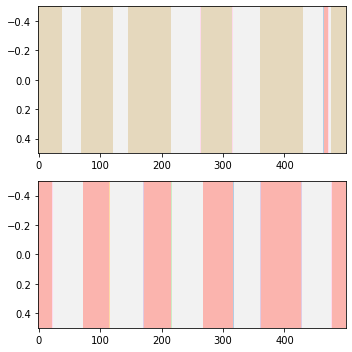

In [25]:
# dynamics_fit[99]['states']
iter_show = gg

plt.rcParams['figure.figsize'] = [5, 5]
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})
a0.imshow(dynamics_fit[iter_show]['states'][None,:], aspect="auto", cmap='Pastel1')
a1.imshow(lab_t[None,:], aspect="auto", cmap='Pastel1')
f.tight_layout()


In [26]:
import shelve

bk = shelve.open('mcmc_unlabel_sim2_v_tmp.pkl','n')
for k in dir():
    try:
        bk[k] = globals()[k]
    except Exception:
        pass
bk.close()